In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
df = pd.read_csv("data/stellar.csv")

In [3]:
df.drop('Unnamed: 0', axis='columns', inplace=True)

In [4]:
# recode response variable to 0/1/2
df = df.replace({"class": {"STAR": 0, "GALAXY": 1, "QSO": 2}})

# Trial 2

In [5]:
target = df['class'].copy()
data = df.drop(columns=['class']).copy()

In [6]:
target.value_counts()

1    47556
0    17275
2    15169
Name: class, dtype: int64

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [10]:
# create KNN model object
knn = KNeighborsClassifier(n_neighbors=5)

In [11]:
# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)



In [12]:
# fit model with 5-fold CV
results = cross_val_score(knn, X_train_std, y_train, cv=kfold)
np.round(results, 3)

In [2]:
# create KNN model object
knn = KNeighborsClassifier()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(1, 50, 10)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold)
results = grid_search.fit(X_train_std, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

NameError: name 'kfold' is not defined

In [18]:
# Best model's k value
optimal_k = results.best_estimator_.get_params().get('n_neighbors')
optimal_k

1

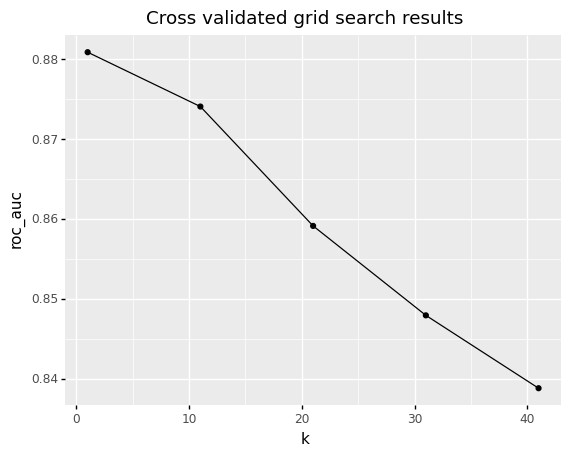

<ggplot: (8740691589440)>

In [19]:
# Plot all RMSE results
all_errors = pd.DataFrame({
  'k': range(1, 50, 10),
  'roc_auc': results.cv_results_['mean_test_score']
  })

(ggplot(all_errors, aes(x='k', y='roc_auc'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

In [20]:
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best_fit = knn_best.fit(X_train_std, y_train)



In [21]:
# create ROC curve
plot_roc_curve(knn_best_fit, X_train_std, y_train)  
plt.show()

ValueError: KNeighborsClassifier should be a binary classifier

In [ ]:
predictions = knn_best_fit.predict(X_train_std)
cm = confusion_matrix(y_train, predictions)
cm

In [ ]:
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=knn_best_fit.classes_
  )
  
disp.plot()

In [ ]:
r = permutation_importance(
  knn_best_fit, 
  X_train_std, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

In [ ]:
pd_results = partial_dependence(
  knn_best_fit, X_train_std, features=1, kind='average',
  percentiles=(0, 1)) 
  
  
pd_output = pd.DataFrame({'glucose': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('glucose', 'yhat'))
  + geom_line())